In [ ]:
library("dplyr")
library("Seurat")
library("patchwork")
library("Matrix")
library("biomaRt")  
library("ggplot2")
library("celda")  
library("DoubletFinder") 
library("hdf5r")
library("harmony") 
library("presto")  
set.seed(1234)

## Import data

### DIV15

In [ ]:
counts15 <- Read10X("/filtered_feature_bc_matrix", gene.column = 1)  
counts15 <- counts15[grep(x = rownames(counts15), pattern = 'GRCh38_w_Barcode_'), ]
rownames(counts15) <- gsub(x = rownames(counts15), pattern = 'GRCh38_w_Barcode_', replacement = "")
div15 <- CreateSeuratObject(counts15, project = "DIV15", min.cells = 3, min.features = 200)

### DIV35

In [ ]:
input_dirs <- c("/MR24_STR_progenitors_DIV35_S29/outs/")

Run_DecontX = function(input_dir, organism_of_interest = "GRCh38_w_Barcode_", min.cells = 3, min.features = 200, use.raw = TRUE) {
    sample_name <- basename(dirname(input_dir))
    #import filtered and raw counts and filter for organism of interest
    counts <- Read10X(paste0(input_dir, "filtered_feature_bc_matrix/"), gene.column = 1)
    counts <- counts[grep(x = rownames(counts), pattern = organism_of_interest), ]
    rownames(counts) <- gsub(x = rownames(counts), pattern = organism_of_interest, replacement = "")
    if (use.raw == TRUE) {
      counts.raw <- Read10X(paste0(input_dir, "raw_feature_bc_matrix/"), gene.column = 1)
      counts.raw <- counts.raw[grep(x = rownames(counts.raw), pattern = organism_of_interest), ]
      rownames(counts.raw) <- gsub(x = rownames(counts.raw), pattern = organism_of_interest, replacement = "")
      #create SingleCellExperiment objects
      sce <- SingleCellExperiment(list(counts = counts))
      sce.raw <- SingleCellExperiment(list(counts = counts.raw))
      #Run DecontX
      sce <- decontX(sce, background = sce.raw)
    } else {
      #create SingleCellExperiment objects
      sce <- SingleCellExperiment(list(counts = counts))
      #Run DecontX
      sce <- decontX(sce)   
    }
    # Create a Seurat object from a SCE with decontX results
    seuratObject <- CreateSeuratObject(round(decontXcounts(sce)), project = "DIV35", min.cells = min.cells, min.features = min.features)   
    return(seuratObject)
}

div35 <- Run_DecontX(input_dir = input_dirs[1], use.raw = TRUE)     

### DIV15 + DIV35

In [ ]:
div50 <- merge(div15, y = div35, 
             add.cell.ids = c("div15", "div35"), project = "vitro")

### Mitochondrial percentage

In [ ]:
div50 <- JoinLayers(div50, assay = 'RNA')
rownames(div50@assays$RNA@layers$counts) <- rownames(div50)

In [ ]:
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mito_genes <- getBM(attributes = c("ensembl_gene_id", "external_gene_name", "chromosome_name"),
                    filters = "chromosome_name", values = "MT", mart = ensembl)
mito_genes <- mito_genes$ensembl_gene_id[mito_genes$ensembl_gene_id %in% rownames(div50)]
div50$percent.mt <- PercentageFeatureSet(div50, features = mito_genes, assay = 'RNA')

### QC filters

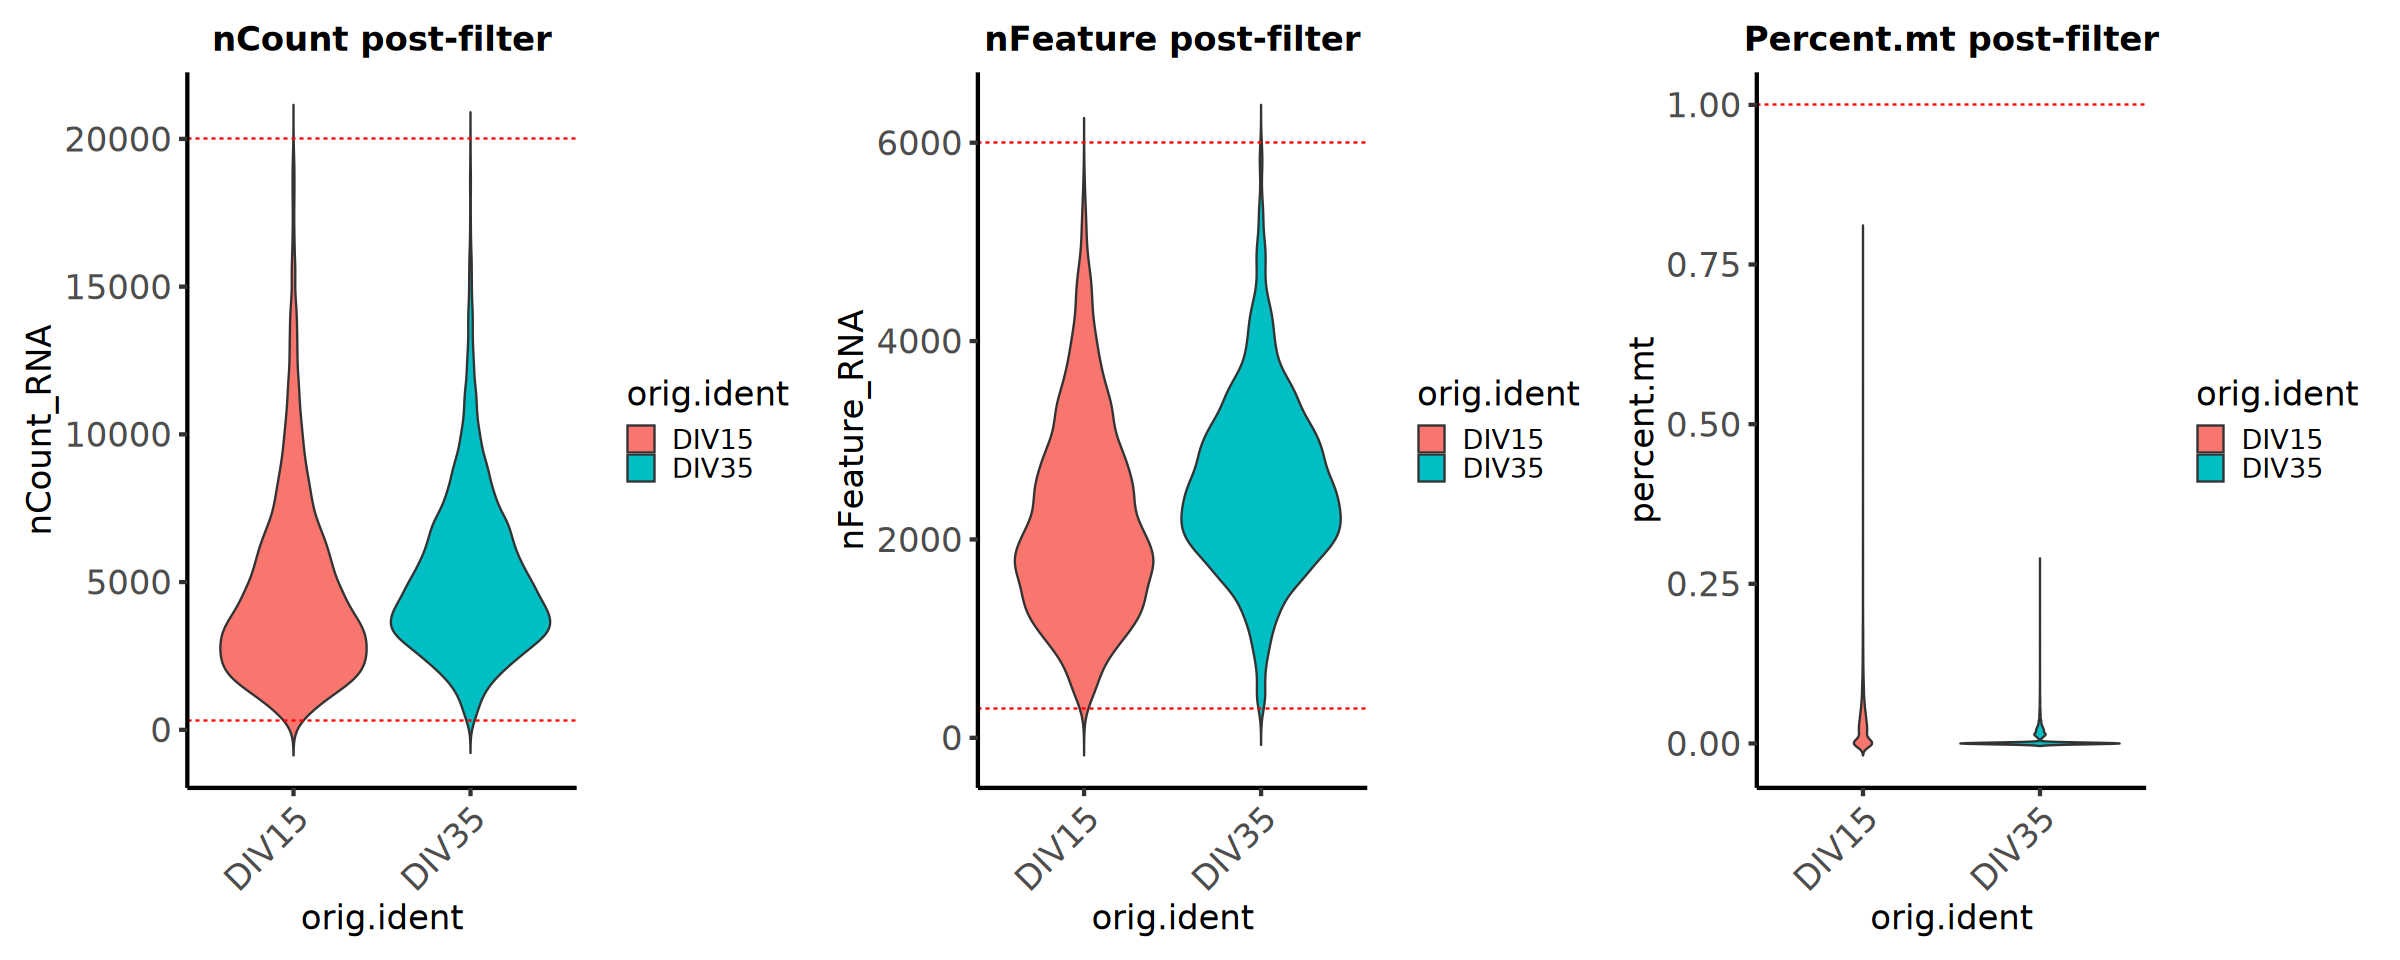

In [230]:
div50 <- subset(div50, subset = nFeature_RNA > 300 & nFeature_RNA < 6000 & nCount_RNA > 300 & nCount_RNA < 20000 & percent.mt < 1)

p1 <- ggplot(div50@meta.data, aes(x=orig.ident, y=nCount_RNA, fill=orig.ident)) + geom_violin(trim=FALSE) + 
        geom_hline(yintercept= c(300, 20000), linetype="dashed", color = "red") + theme_classic(base_size = 20) + 
        theme_classic(base_size = 20) +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 20), 
              axis.text.y = element_text(size = 20),
             plot.title = element_text(size = 20, hjust = 0.5, face = "bold")) +
        ggtitle("nCount post-filter")

p2 <- ggplot(div50@meta.data, aes(x=orig.ident, y=nFeature_RNA, fill=orig.ident)) + geom_violin(trim=FALSE) + 
        geom_hline(yintercept= c(300, 6000), linetype="dashed", color = "red") + theme_classic(base_size = 20) + 
        theme_classic(base_size = 20) +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 20), 
              axis.text.y = element_text(size = 20),
             plot.title = element_text(size = 20, hjust = 0.5, face = "bold")) +
        ggtitle("nFeature post-filter")

p3 <- ggplot(div50@meta.data, aes(x=orig.ident, y=percent.mt, fill=orig.ident)) + geom_violin(trim=FALSE) + 
        geom_hline(yintercept= 1, linetype="dashed", color = "red") + theme_classic(base_size = 20) + 
        theme_classic(base_size = 20) +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 20), 
              axis.text.y = element_text(size = 20),
             plot.title = element_text(size = 20, hjust = 0.5, face = "bold")) +
        ggtitle("Percent.mt post-filter")  

wrap_plots(p1, p2, p3)

### Clustering & UMAP loop

In [ ]:
div50 <- SCTransform(div50, vst.flavor = "v2", variable.features.n = 3000,  ncells = 5000, verbose = F)  

human_sub_genes <- readRDS('/GTF_HumanGenes_IDandName_subsetted.rds')
human_s.genes <- subset(human_sub_genes, subset = name %in% cc.genes$s.genes)
s.genes <- human_s.genes$gene_id
human_g2m.genes <- subset(human_sub_genes, subset = name %in% cc.genes$g2m.genes)
g2m.genes <- human_g2m.genes$gene_id

#Cell cycle scoring
div50 <- CellCycleScoring(div50, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
div50$CC.Difference <- div50$S.Score - div50$G2M.Score
#PCA on highly variable genes
div50 <- RunPCA(div50, features = VariableFeatures(object = div50), npcs = 50, reduction.name = "pca")
ElbowPlot(div50, reduction = "pca", ndims = 50)
div50 <- RunUMAP(div50, dims = 1:num_dims, reduction = "pca", reduction.name = "umap", reduction.key = "umap", verbose = F)

### Batch integration

In [ ]:
div50 <- RunHarmony(div50, 'orig.ident', orig.reduction = "pca", reduction.name = "harmonyPca", assay = "SCT", verbose = FALSE)

#Clustering loop
num_dims <- 30
div50 <- FindNeighbors(div50, reduction = "harmony", dims = 1:num_dims)
for (res_val in seq(0.05, 0.85, 0.2)) {
  div50 <- FindClusters(div50, resolution = res_val, method = 4)
  div50 <- RunUMAP(div50, dims = 1:num_dims, reduction = "harmony", reduction.name = "harmony_umap")
}

## Annotation

In [ ]:
div50$annotation_markers <- ifelse(div50$SCT_snn_res.0.25 == 0 | div50$SCT_snn_res.0.25 == 7, 'Neural Progenitors',
                                ifelse(div50$SCT_snn_res.0.25 == 3 |div50$SCT_snn_res.0.25 == 6 | div50$SCT_snn_res.0.25 == 5, 'GE Progenitors', 
                                ifelse(div50$SCT_snn_res.0.25 == 8 | div50$SCT_snn_res.0.25 == 1, 'Emerging MSNs', 
                                ifelse(div50$SCT_snn_res.0.25 == 4 | div50$SCT_snn_res.0.25 == 2, 'MGE int. precursors',
                                       div50$annotation_markers))))

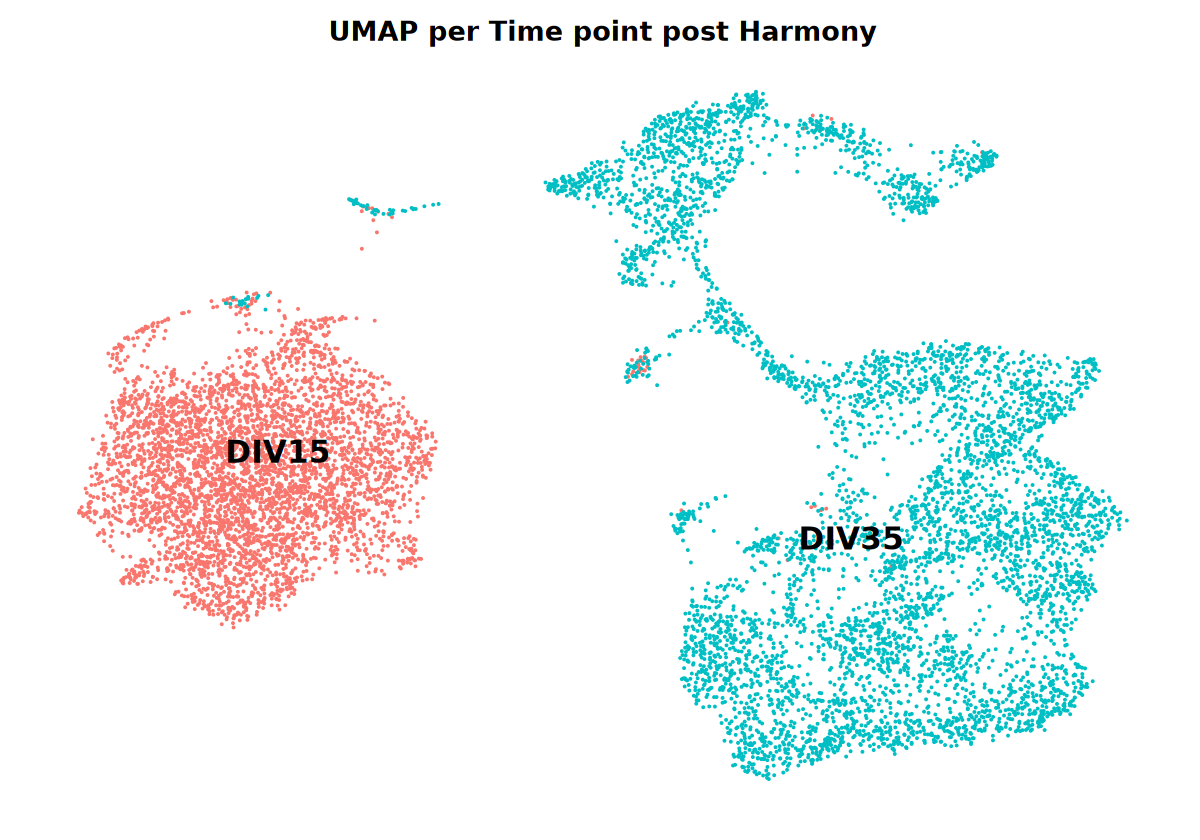

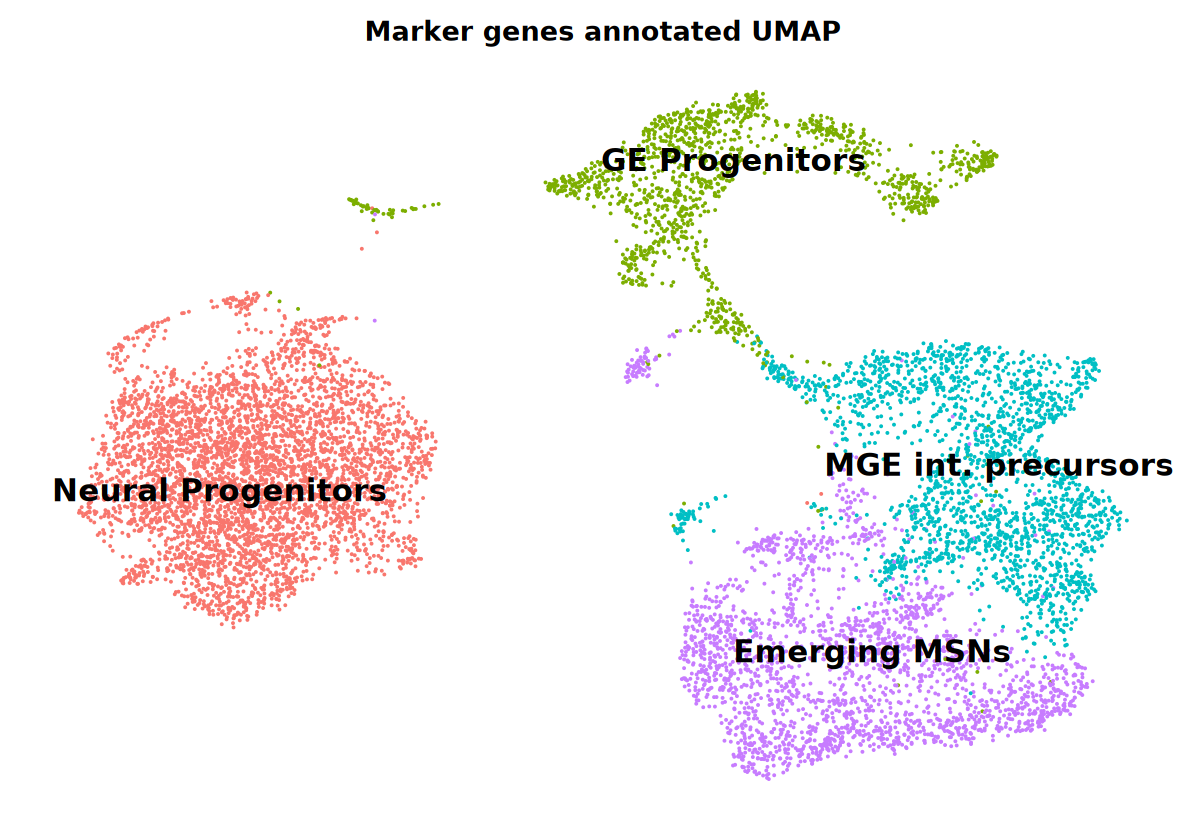

In [187]:
p1 <- DimPlot(div50, reduction = 'harmony_umap', group.by = 'orig.ident', pt.size = 0.05) +
        ggtitle('UMAP per Time point post Harmony') +
        NoAxes() + NoLegend() 
LabelClusters(p1, id = "orig.ident",  fontface = "bold", size = 6.5)  

p2 <- DimPlot(div50, reduction = 'harmony_umap', group.by = 'annotation_markers', pt.size = 0.05) + 
        ggtitle('Marker genes annotated UMAP') +
        NoAxes() + NoLegend() 
LabelClusters(p2, id = "annotation_markers",  fontface = "bold", size = 6.5)

## Marker plots

In [ ]:
marker_genes <- list(
    'Neural Progenitors' = c("ENSG00000105810", #CDK6
                             "ENSG00000148773", #MKI67
                             "ENSG00000170312", #CDK1
                             "ENSG00000131747", #TOP2A
                             "ENSG00000132688", #NES
                             "ENSG00000026025" #VIM
                            ),
    
    'GE Progenitors' = c("ENSG00000146592", #CREB5
                         "ENSG00000147862", #NFIB
                         "ENSG00000181449", #SOX2
                         "ENSG00000134595", #SOX3
                         "ENSG00000180613", #GSX2
                         "ENSG00000197921", #HES5
                         "ENSG00000139352", #ASCL1
                         "ENSG00000144355", #DLX1
                         "ENSG00000115844" #DLX2
                         ),      
    
    'MGE int. precursors' = c("ENSG00000128683", #GAD1
                             "ENSG00000136750", #GAD2
                             "ENSG00000178568", #ERBB4
                             "ENSG00000110693", #SOX6
                             "ENSG00000231764", #DLX6-AS1
                             "ENSG00000127152", #BCL11B
                             "ENSG00000077279", #DCX
                             "ENSG00000106852"),#LHX6
    
    'Emerging MSNs' = c("ENSG00000140836", #ZFHX3
                        "ENSG00000157168", #NRG1
                        "ENSG00000164330", #EBF1
                        "ENSG00000016082") #ISL1
                         )

In [ ]:
ensembl_to_symbol <- c(
      #Neural Progenitors
     "ENSG00000105810" = 'CDK6', "ENSG00000148773" = 'MKI67', "ENSG00000170312" = 'CDK1', "ENSG00000131747" = 'TOP2A', "ENSG00000132688" = 'NES', "ENSG00000026025" = 'VIM',
    
      #GE progenitors
      "ENSG00000146592" = 'CREB5', "ENSG00000147862" = 'NFIB', 'ENSG00000277015' = 'SALL3', "ENSG00000181449" = 'SOX2',    
                 "ENSG00000134595" = 'SOX3', "ENSG00000180613" = 'GSX2', "ENSG00000197921" = 'HES5', "ENSG00000139352" = 'ASCL1', "ENSG00000144355" = 'DLX1', "ENSG00000115844" = 'DLX2', 
                              
      #MGE int. precursors
     "ENSG00000128683" = 'GAD1', "ENSG00000136750" = 'GAD2', "ENSG00000178568" = 'ERBB4', "ENSG00000110693" = 'SOX6', "ENSG00000231764" = 'DLX6-AS1', "ENSG00000127152" = 'BCL11B', 
             "ENSG00000077279" = 'DCX', "ENSG00000106852" = 'LHX6', 
    
      #Emerging MSN
      "ENSG00000140836" = 'ZFHX3', "ENSG00000157168" = 'NRG1', "ENSG00000164330" = 'EBF1',"ENSG00000016082" = 'ISL1')

Warning message:
“The following requested variables were not found: ENSG00000277015”
Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


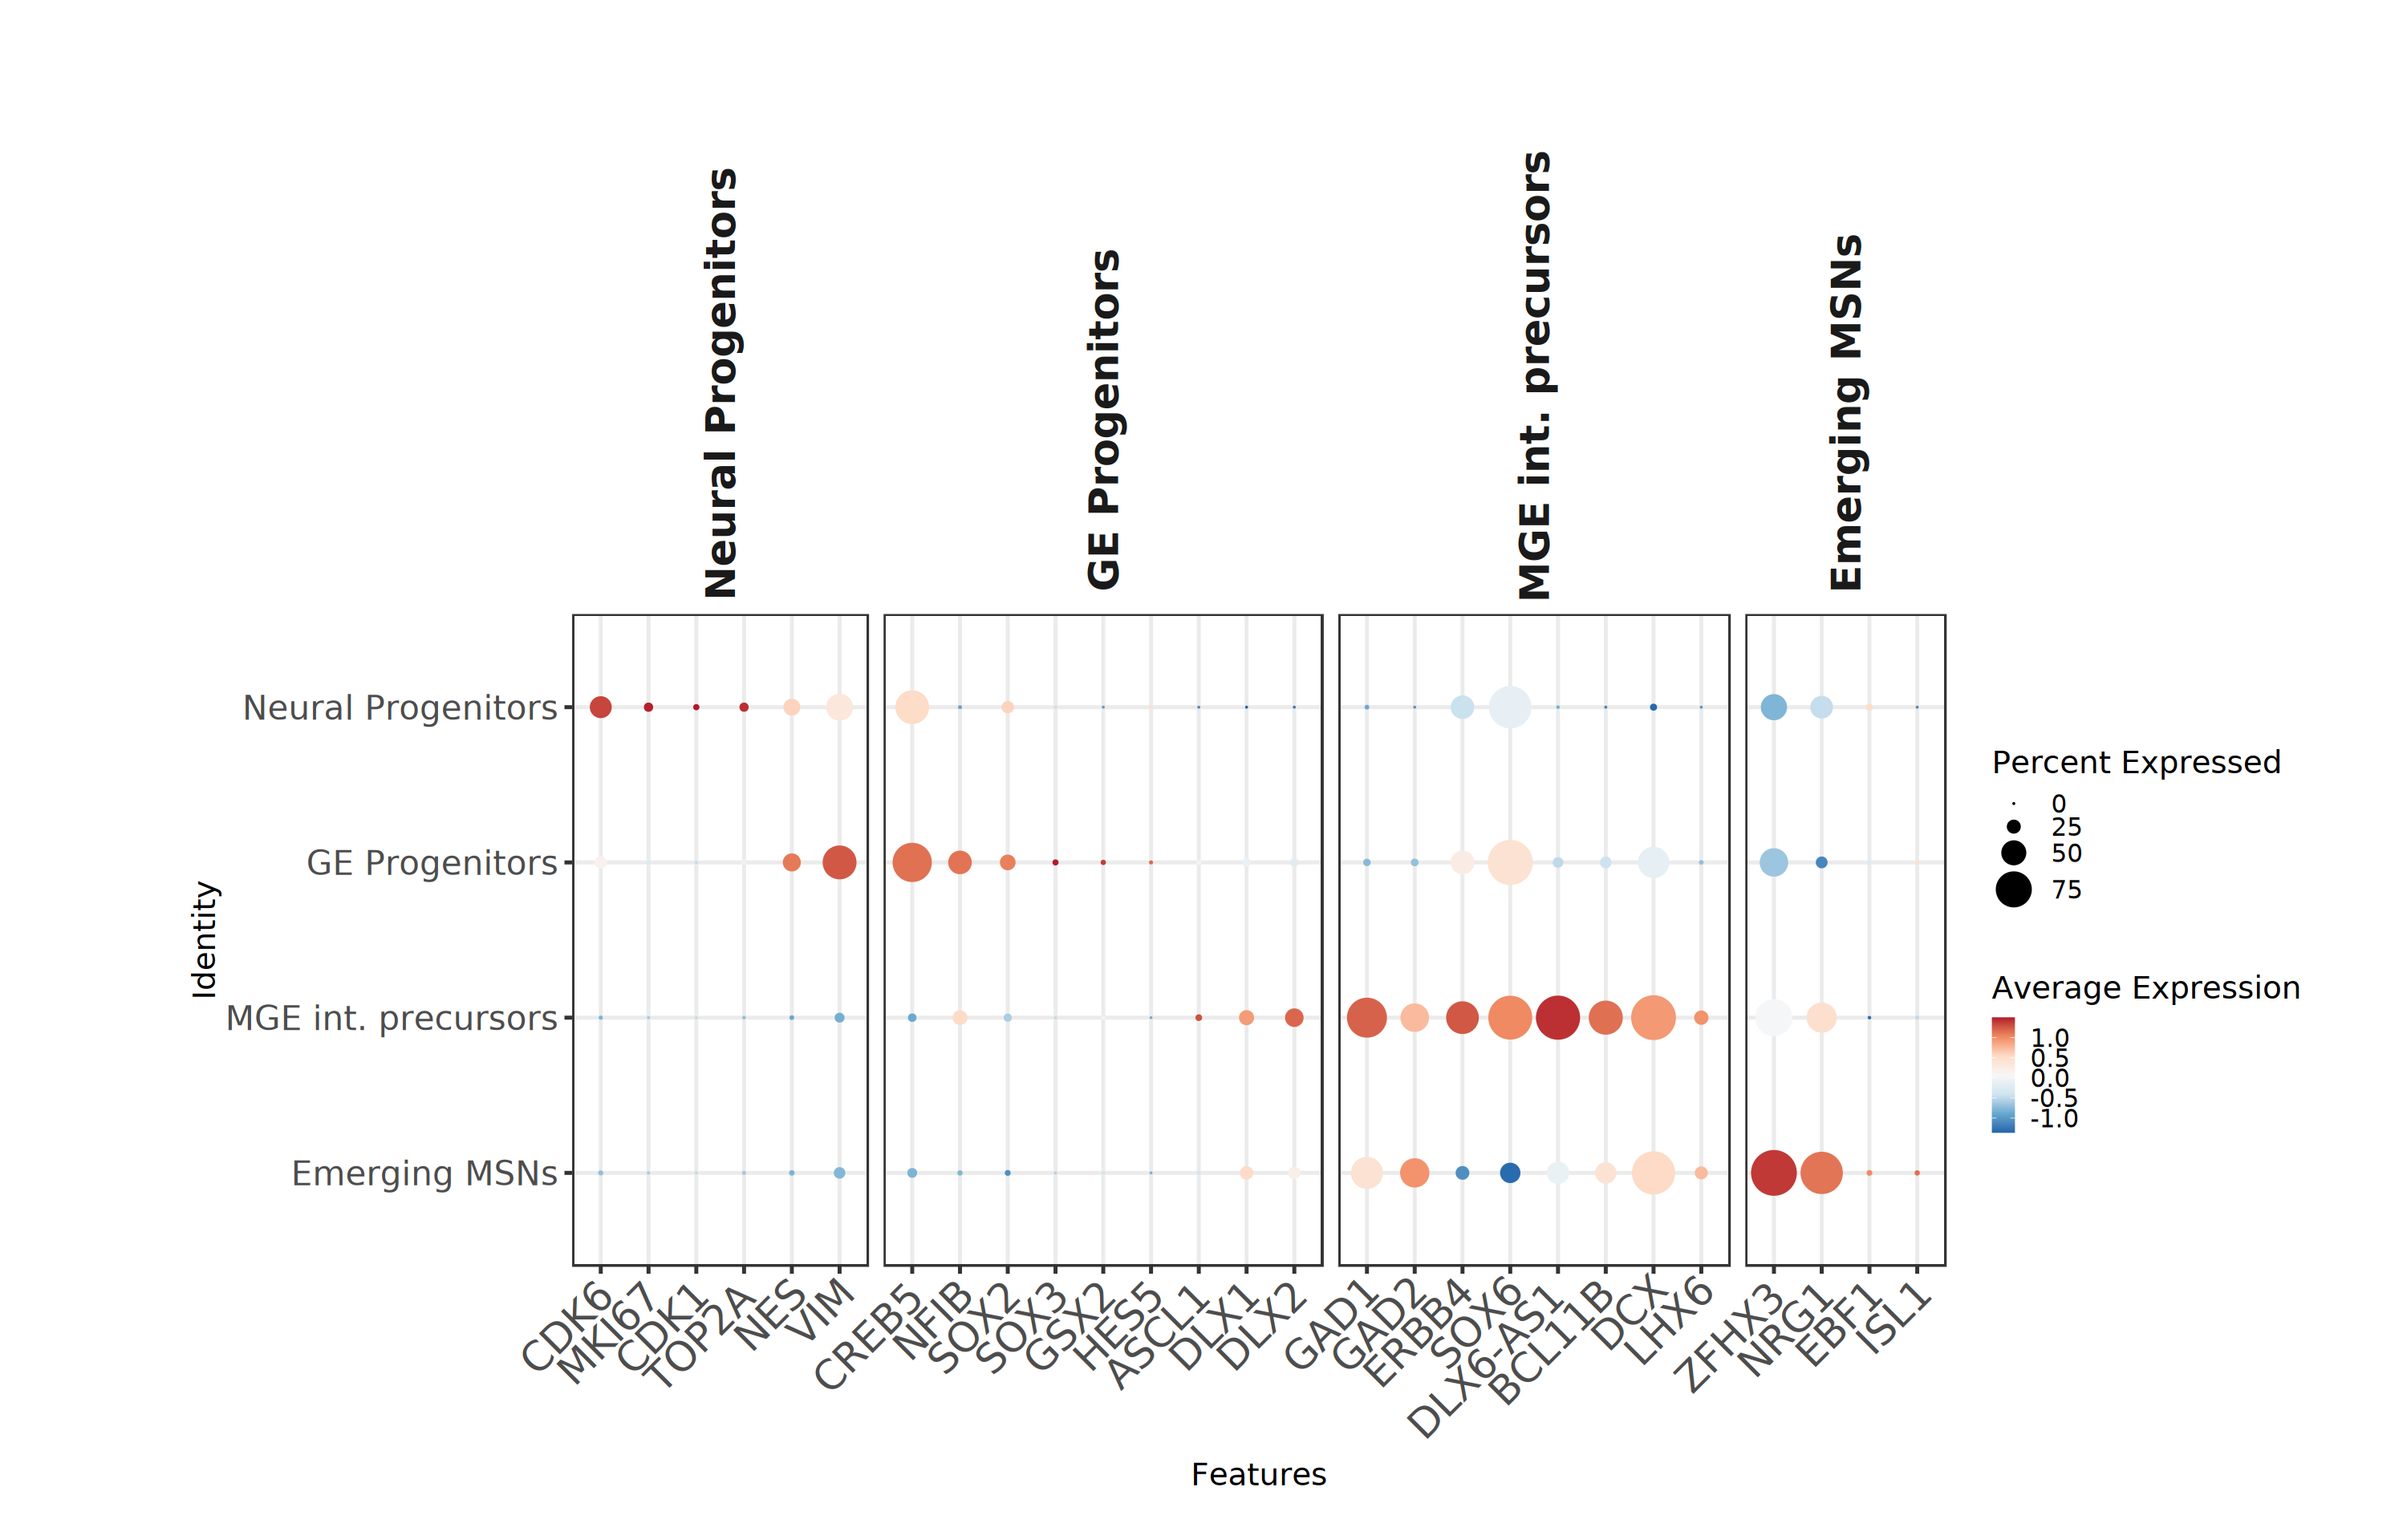

In [212]:
options(repr.plot.width=25, repr.plot.height=16)  

markers_plot <- DotPlot(object = div50, features = marker_genes, group.by = "annotation_markers", dot.scale = 15) 
  
markers_plot + theme_bw(base_size = 23) +
    scale_color_distiller(palette= "RdBu", direction = -1) +  
        theme(axis.text.x = element_text(size = 30, angle = 45, hjust = 1.1, vjust = 1.1),
          axis.text.y = element_text(size = 25),
         strip.text.x = element_text(face = 'bold', size = 30, angle = 90, hjust = 0.1, vjust = 0.5),
         strip.background = element_blank(), 
         plot.margin = unit(c(1.5, 1, 0.5, 2), "inches")) +
    scale_y_discrete(limits = rev(c("Neural Progenitors", "GE Progenitors", "MGE int. precursors", "Emerging MSNs"))) +
    scale_x_discrete(labels = function(x) ensembl_to_symbol[x])  

#### DotPlot astro specific

In [190]:
astro_marker_genes <- c('ENSG00000171885',  # AQP4
                        'ENSG00000131095',  # GFAP
                        'ENSG00000100146',  # SOX10
                        'ENSG00000160307',  # S100B
                        'ENSG00000125398',  # SOX9
                        'ENSG00000205927'   # OLIG2
                       )                   

In [191]:
ensembl_to_symbol_astro <- c('ENSG00000171885' = 'AQP4', 'ENSG00000131095' = 'GFAP', 'ENSG00000100146' = 'SOX10',
'ENSG00000160307' = 'S100B', 'ENSG00000125398' = 'SOX9', 'ENSG00000205927' = 'OLIG2')

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


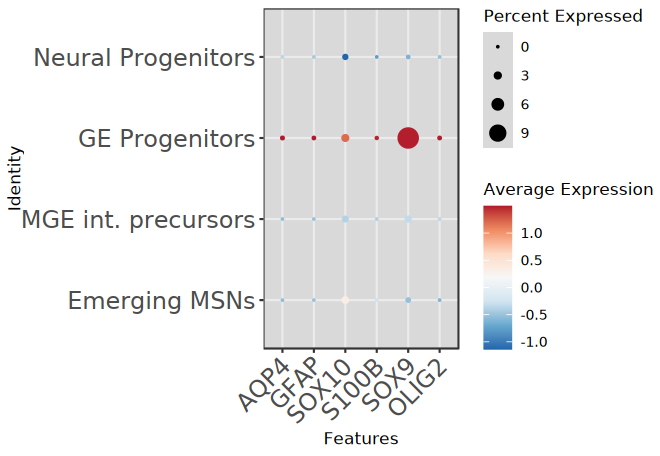

In [199]:
options(repr.plot.width=5.5, repr.plot.height=3.8)   #for graphs

div50@meta.data$annotation_markers <- factor(div50@meta.data$annotation_markers, levels = c("Neural Progenitors", "GE Progenitors", "MGE int. precursors", "Emerging MSNs"))
markers_plot_astro <- DotPlot(object = div50, features = astro_marker_genes, group.by = "annotation_markers", dot.scale = 5) 
  
markers_plot_astro + theme_bw(base_size = 10) +
    scale_color_distiller(palette= "RdBu", direction = -1) +
    theme(axis.text.x = element_text(size = 14, angle = 45, hjust = 1.1, vjust = 1.1),
          axis.text.y = element_text(size = 14),
          strip.background = element_rect(fill = NA, color = "black", size = 0.8),
          panel.background = element_rect(fill = "grey85", color = NA)   
             ) +
        scale_y_discrete(limits = rev(c("Neural Progenitors", "GE Progenitors", "MGE int. precursors", "Emerging MSNs"))) +
    scale_x_discrete(labels = function(x) ensembl_to_symbol_astro[x])

### DEGs Heatmap

In [ ]:
Idents(div50) <- div50$annotation_markers
dea_ct <- FindAllMarkers(div50, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, assay = "SCT")

In [ ]:
dea_ct <- dea_ct[order(dea_ct$avg_log2FC, decreasing = TRUE),]
dea_ct_fil <- dea_ct[dea_ct$p_val_adj < 0.05,]

top_marker_ct <- dea_ct_fil %>%
  group_by(cluster) %>%
  slice_max(n = 50, order_by = avg_log2FC)

In [ ]:
# Conversione in gene symbol
top_marker_ct$cluster <- factor(top_marker_ct$cluster, levels = c("Neural Progenitors", "GE Progenitors", "MGE int. precursors", "Emerging MSNs"))
mart <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
    complete_degs_ct <- data.frame()

for (clust in levels(top_marker_ct$cluster)) { 
    
    # Filtro per i marker significativi nel cluster specifico
    c_tf <- top_marker_ct[top_marker_ct$cluster == clust,]
    ensembl_ids <- c_tf$gene
    
    # Recupero dei simboli dei geni da Ensembl
    gene_symbols <- tryCatch({
        getBM(attributes = c("ensembl_gene_id", "hgnc_symbol"),
              filters = "ensembl_gene_id",
              values = ensembl_ids,
              mart = mart)
    }, error = function(e) {
        return(data.frame(ensembl_gene_id = character(0), hgnc_symbol = character(0)))
    })
    
    c_tf <- merge(c_tf, gene_symbols, by.x = "gene", by.y = "ensembl_gene_id", all.x = TRUE, sort = FALSE)
        complete_degs_ct <- rbind(complete_degs_ct, c_tf)
   }

Warning message in DoHeatmap(div50, features = degs_heatmap, size = 5, group.bar.height = 0.005, :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: ENSG00000015592, ENSG00000110076, ENSG00000115844, ENSG00000105880”


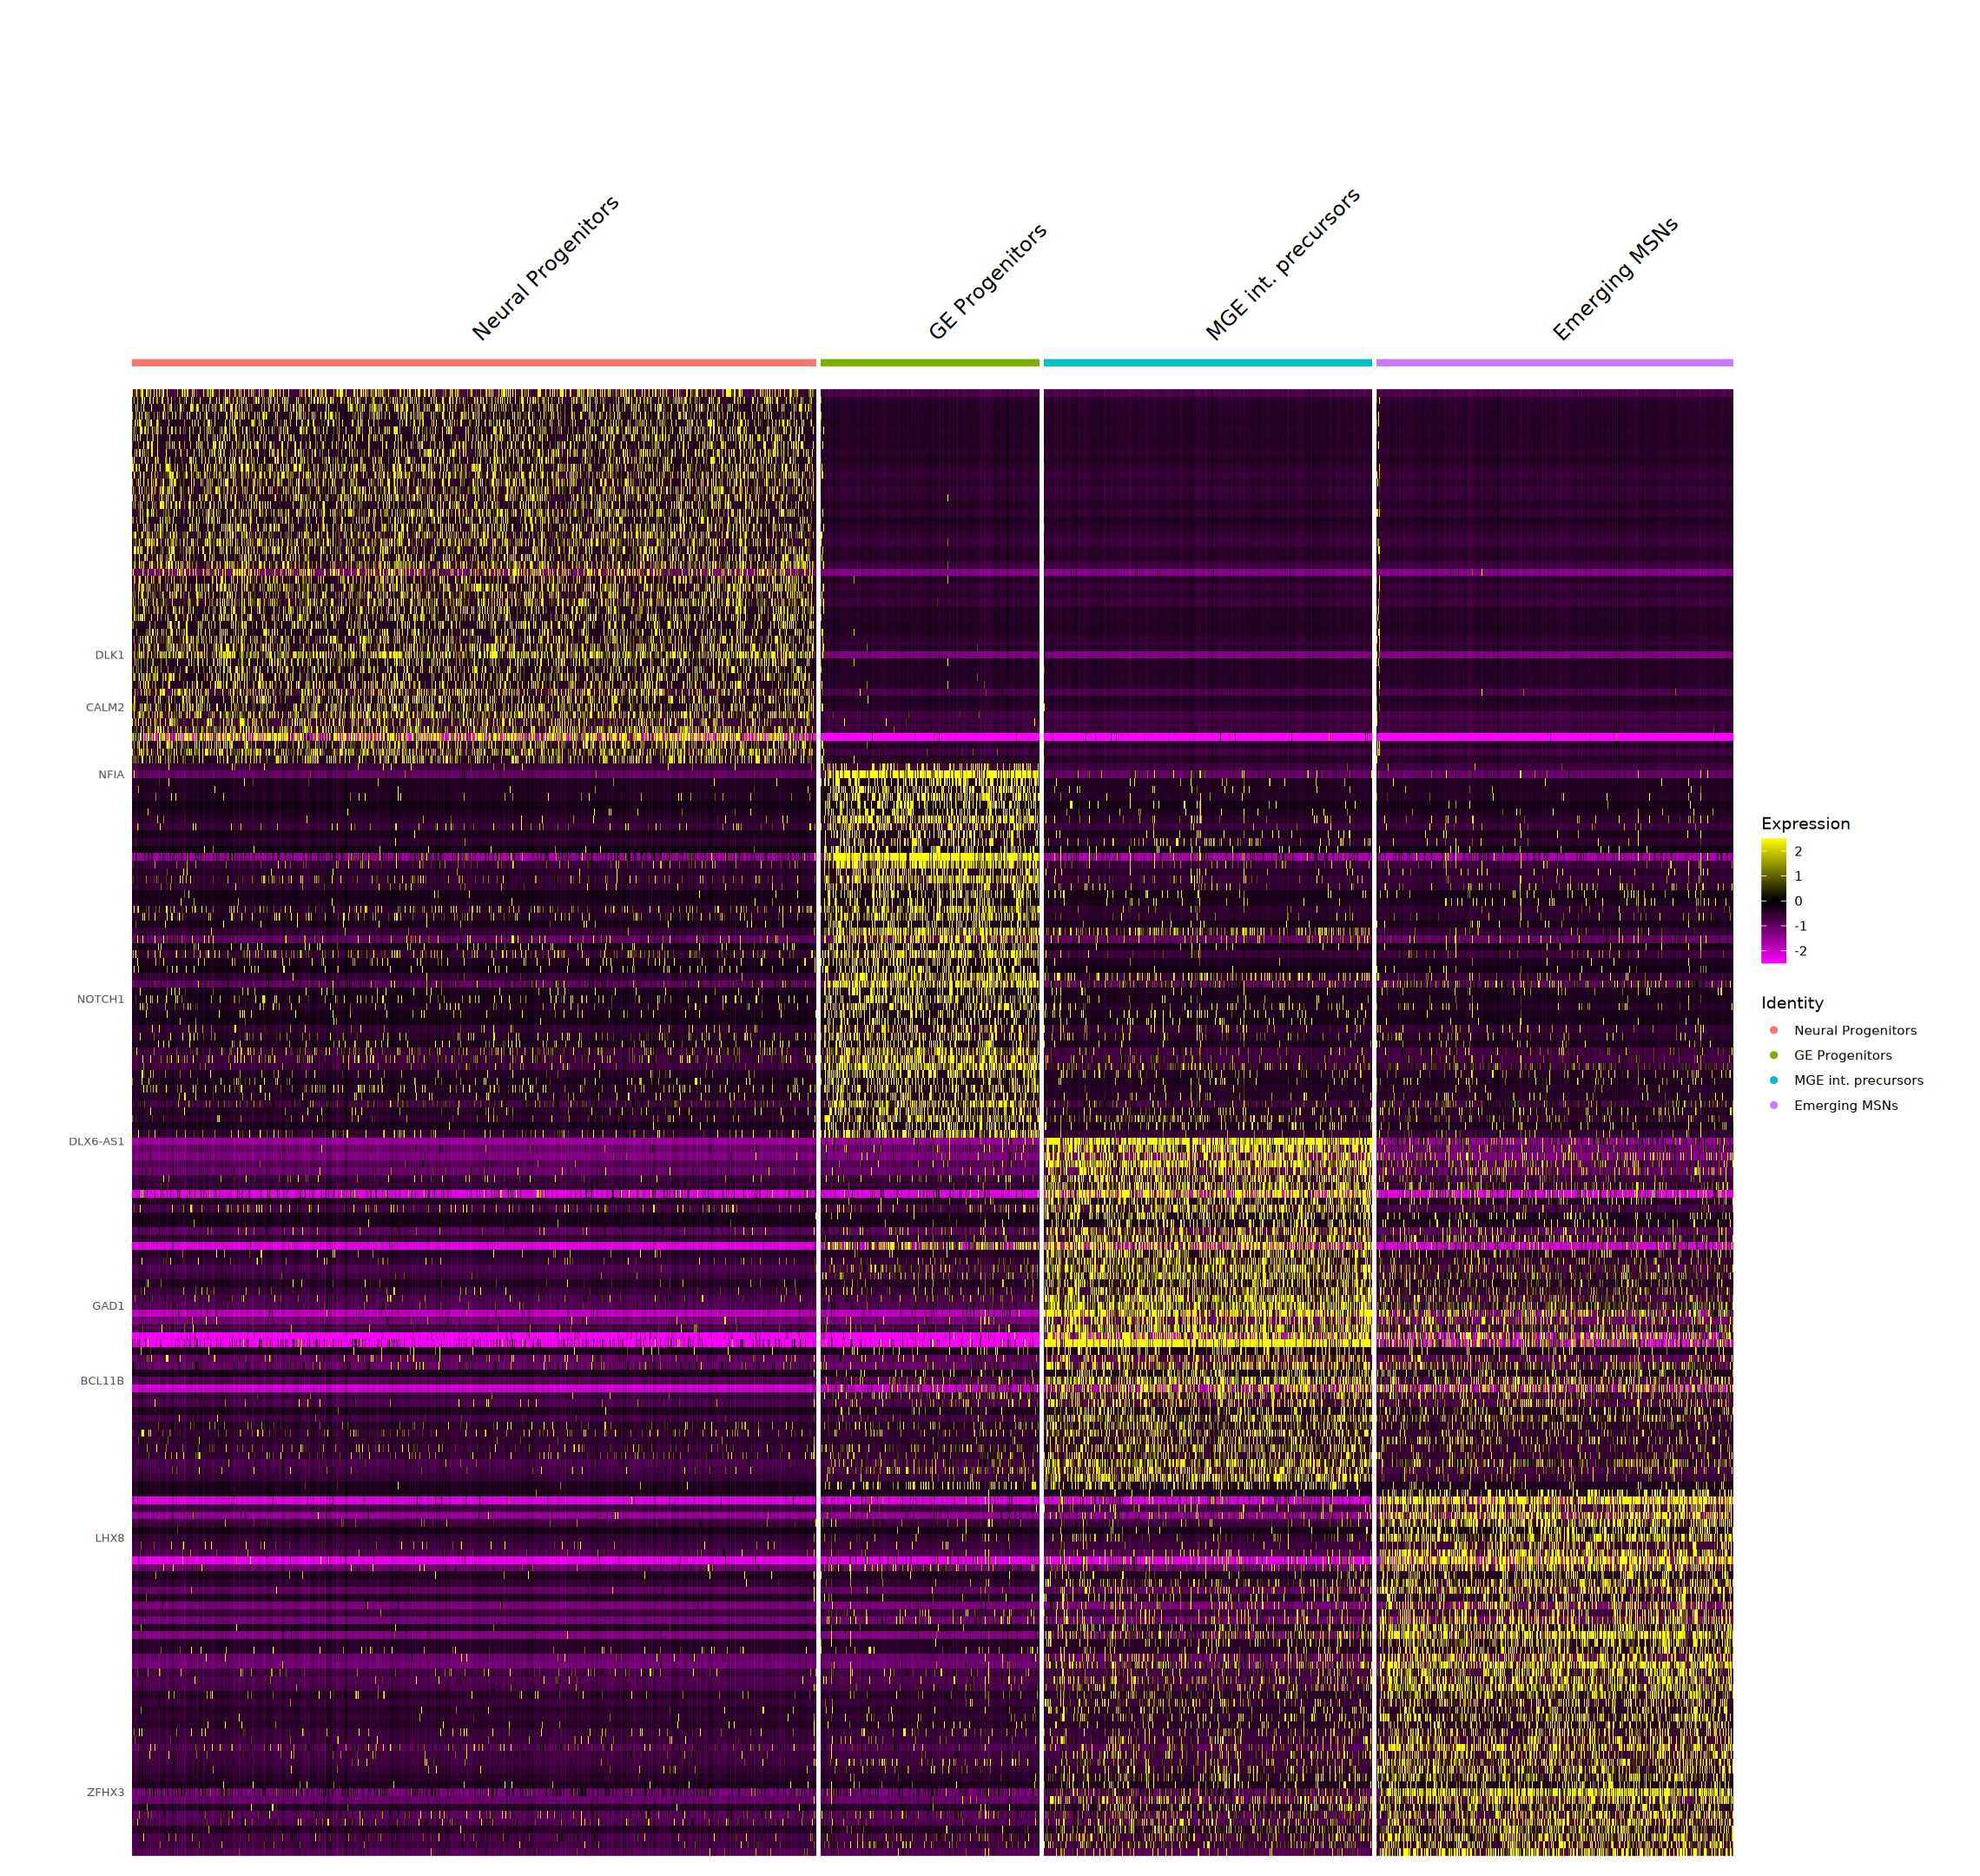

In [41]:
options(repr.plot.width=19, repr.plot.height=18)

div50@meta.data$annotation_markers <- factor(div50@meta.data$annotation_markers, levels = c("Neural Progenitors", "GE Progenitors", "MGE int. precursors", "Emerging MSNs"))


degs_heatmap <- complete_degs_ct$gene
genes_to_label <- c(
    #Neural Progenitors
    "ENSG00000132688" = 'NES', "ENSG00000026025" = 'VIM', "ENSG00000105810" = 'CDK6', "ENSG00000148773" = 'MKI67', "ENSG00000170312" = 'CDK1', "ENSG00000131747" = 'TOP2A',
    'ENSG00000185559' = 'DLK1', 'ENSG00000143933' = 'CALM2', 
    
      #GE progenitors
     "ENSG00000146592" = 'CREB5', "ENSG00000147862" = 'NFIB',  "ENSG00000181449" = 'SOX2', "ENSG00000134595" = 'SOX3', "ENSG00000180613" = 'GSX2', "ENSG00000197921" = 'HES5', 
     "ENSG00000139352" = 'ASCL1', "ENSG00000144355" = 'DLX1', "ENSG00000115844" = 'DLX2', "ENSG00000148400" = 'NOTCH1', 'ENSG00000162599' = 'NFIA', 
                              
      #MGE int. precursors
    "ENSG00000128683" = 'GAD1', "ENSG00000136750" = 'GAD2', "ENSG00000178568" = 'ERBB4', "ENSG00000110693" = 'SOX6', "ENSG00000231764" = 'DLX6-AS1', "ENSG00000127152" = 'BCL11B', 
    "ENSG00000077279" = 'DCX', "ENSG00000106852" = 'LHX6', "ENSG00000162624" = 'LHX8',
    
    #Emerging MSN
    "ENSG00000140836" = 'ZFHX3', "ENSG00000157168" = 'NRG1', "ENSG00000164330" = 'EBF1',"ENSG00000016082" = 'ISL1')


heatmap <- DoHeatmap(div50, features = degs_heatmap, size = 5, group.bar.height = 0.005, group.by = 'annotation_markers')

gene_order <- levels(heatmap$data$Feature)

#Show only DEGs present in genes_to_label (markers used)
y_labels <- sapply(gene_order, function(gene) {
    ifelse(gene %in% names(genes_to_label), genes_to_label[gene], "")
})

heatmap +
    scale_y_discrete(labels = y_labels) +
        theme(plot.margin = unit(c(1.5,1,0,1.5), "cm"),
          axis.text.y = element_text(size = 7.5))